## Donut 🍩, Document understanding transformer

![model image](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/donut_architecture.jpg)

[paper: OCR-free Document Understanding Transformer](https://huggingface.co/papers/2111.15664)

[clovaai/donut Github](https://github.com/clovaai/donut?tab=readme-ov-file)

[donut-base model on huggingface](https://huggingface.co/naver-clova-ix/donut-base/)


### TEXT FORMAT

**during training:**

- **INPUT:**
  - Image embedding
  - task_start_token + bos_token + json2token(ground_truth_json) + eos_token

**during inference:**

- **INPUT:**
  - Image embedding
  - task_start_token

- **OUTPUT:**
  - ground_truth_json

In [ ]:
!pip show transformers

Name: transformers
Version: 4.56.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
!git clone https://github.com/hftuner/clovaai-donut.git /content/hftuner

Cloning into '/content/hftuner'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 1), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.20 MiB | 2.51 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import os
import json
from datasets import load_dataset

dataset = load_dataset('hf-tuner/rvl-cdip-document-classification')

class_names = dataset['train'].features['label'].names
id2label = {i: c for i, c in enumerate(class_names)}

# add ground truth
def add_gt(example):
  class_name = id2label[example['label']]
  example["ground_truth"] = json.dumps({
      "gt_parse":{
          "class": class_name # str
      }
  })
  return example

dataset = dataset.map(add_gt)

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/992 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

In [ ]:
ignore_id = -100
task_start_token = "<classification>"
new_special_tokens = []

# add tokens from class_names
for class_name in class_names:
  class_name = class_name.replace(" ","_")
  new_special_tokens.append(class_name)

new_special_tokens.extend([task_start_token])
new_special_tokens

['letter',
 'form',
 'email',
 'handwritten',
 'advertisement',
 'scientific_report',
 'scientific_publication',
 'specification',
 'file_folder',
 'news_article',
 'budget',
 'invoice',
 'presentation',
 'questionnaire',
 'resume',
 'memo',
 '<classification>']

In [ ]:
from hftuner.donut import DataProcessor

data_processor = DataProcessor()
json2token = data_processor.json2token

example_document_classification_gt = {"class" : "scientific_report"} #gt_parse

json2token(example_document_classification_gt)

'<s_class>scientific_report</s_class>'

## special tokens from dataset

In [ ]:
def clean_docs_for_donut(sample):
    gt = json.loads(sample["ground_truth"])
    parsed_text = gt['gt_parse'] if 'gt_parse' in gt else gt['gt_parses']
    text = json2token(parsed_text, update_special_tokens_for_json_key=True) # adds a new token for each key
    return {"text": text}

columns_to_remove = [ c for c in dataset['train'].column_names if c not in ['image', 'ground_truth', 'text']]

data_processor.clear_new_special_tokens()
proc_dataset = dataset.map(clean_docs_for_donut, remove_columns=columns_to_remove)
new_key_tokens = data_processor.get_new_special_tokens()

print(f"Sample:\n{proc_dataset['train'][4]['text']}")
# bos_token and eos_token will be added by data collator function

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

Sample:
<s_class>memo</s_class>


## load model and processor

In [ ]:
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig
from hftuner.donut import DonutModel

ckpt = 'naver-clova-ix/donut-base'
processor = DonutProcessor.from_pretrained(ckpt)
model = DonutModel.from_pretrained(ckpt)

len(processor.tokenizer)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

57525

### Configure processor and model for finetuning

In [ ]:
new_special_tokens = list(set(new_special_tokens + new_key_tokens))
print(f"New special tokens:  {new_special_tokens}")

# add new special tokens to tokenizer
print(f"Adding {len(new_special_tokens)} special tokens")
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens})
print(f"New tokenizer length: {len(processor.tokenizer)}")


New special tokens:  ['letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific_report', 'scientific_publication', 'specification', 'file_folder', 'news_article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume', 'memo', '<classification>', '<s_class>', '</s_class>', '<s_class>', '</s_class>', '<s_class>', '</s_class>', '<s_class>', '</s_class>']
Adding 25 special tokens
New tokenizer length: 57542


In [ ]:
# to find max_token to output during training
def add_token_count(example):
  example['tokens_count'] = processor.tokenizer(
      example['text'],
      add_special_tokens=True,
      return_tensors="pt",
  ).input_ids[0].shape[0]
  return example

proc_dataset = proc_dataset.map(add_token_count)
max_length = max(proc_dataset['train']['tokens_count'])
print('maximum length of example:', max_length)



Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

maximum length of example: 6


In [ ]:
max_length = 8
processor_image_size = [720, 960] # (width, height)

## UPDATE: processor
processor.image_processor.size['width'] = processor_image_size[0]
processor.image_processor.size['height'] = processor_image_size[1]
processor.image_processor.do_align_long_axis = False # don't rotate image if height is greater than width

## UPDATE: model

# generation config
model.config.decoder.max_length = max_length
model.config.pad_token_id = processor.tokenizer.pad_token_id
# ⚠️ IMPORTANT: set decoder_start_token
task_token_id = processor.tokenizer.encode(task_start_token, add_special_tokens=False)[0]
model.config.decoder_start_token_id = task_token_id

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))

# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor_image_size[::-1] # (height, width)

print(f"New token embedding size: {new_emb}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New token embedding size: MBartScaledWordEmbedding(57542, 1024, padding_idx=1)


More about : [decoder_start_token_id](https://github.com/huggingface/transformers/blob/4df2529d79d75f44e70396df5888a32ffa02d61e/src/transformers/models/vision_encoder_decoder/modeling_vision_encoder_decoder.py#L331)

## Data Collator

In [ ]:
def prepare_data(examples):
    images = [e['image'].convert("RGB") for e in examples]
    texts = [e['text'] for e in examples]
    # create tensor from image
    pixel_values = processor(
        images,
        return_tensors="pt"
        ).pixel_values
    # tokenize text
    input_ids = processor.tokenizer(
        texts,
        add_special_tokens=True, # add <s> and </s>
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).input_ids
    labels = input_ids.clone()
    # ignore pad tokens when calculating `loss`
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id
    return {"pixel_values": pixel_values, "labels": labels}

# TEST
batch= prepare_data([
    proc_dataset['train'][5],
])
batch.keys(), batch['pixel_values'].shape, batch['labels'].shape

(dict_keys(['pixel_values', 'labels']),
 torch.Size([1, 3, 960, 720]),
 torch.Size([1, 8]))

## ⚙️ Train

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

save_model_name = "donut-base-finetuned-rvl-cdip"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=save_model_name,
    num_train_epochs=1,
    # max_steps = 100,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size =1,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    eval_strategy="no",
    save_strategy="epoch",
    save_total_limit=1,
    # group_by_length=True,
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=save_model_name,
    remove_unused_columns=False
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=prepare_data,
    train_dataset=proc_dataset["train"],
    # eval_dataset=proc_dataset["test"],
)


In [ ]:
# Start training
trainer.train()

Step,Training Loss
100,8.363400
200,4.759600
300,1.600500
400,1.192100
500,1.006500
600,0.825600
700,0.750900
800,0.746900
900,0.640300
1000,0.651100


Step,Training Loss
100,8.363400
200,4.759600
300,1.600500
400,1.192100
500,1.006500
600,0.825600
700,0.750900
800,0.746900
900,0.640300
1000,0.651100


TrainOutput(global_step=8000, training_loss=0.6687937893867493, metrics={'train_runtime': 2633.6166, 'train_samples_per_second': 3.038, 'train_steps_per_second': 3.038, 'total_flos': 1.40711024295936e+19, 'train_loss': 0.6687937893867493, 'epoch': 1.0})

In [ ]:
trainer.save_model(save_model_name)
processor.save_pretrained(save_model_name)

# Save processor and create model card
hf_repo_id = f"hf-tuner/{save_model_name}"
trainer.create_model_card()
trainer.push_to_hub()
processor.push_to_hub(repo_id=hf_repo_id)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...vl-cdip/training_args.bin: 100%|##########| 5.97kB / 5.97kB            

  ...59847.ceb7312e16e6.1202.0: 100%|##########| 23.5kB / 23.5kB            

  ...vl-cdip/model.safetensors:   4%|4         | 33.5MB /  809MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...vl-cdip/training_args.bin: 100%|##########| 5.97kB / 5.97kB            

  ...59847.ceb7312e16e6.1202.0: 100%|##########| 23.5kB / 23.5kB            

  ...vl-cdip/model.safetensors:   3%|3         | 25.2MB /  809MB            

  ...p/sentencepiece.bpe.model:  85%|########4 | 1.10MB / 1.30MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...p/sentencepiece.bpe.model: 100%|##########| 1.30MB / 1.30MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/hf-tuner/donut-base-finetuned-rvl-cdip/commit/78bf3efdf4c00db7eb208628d3f657e2264a0e5e', commit_message='Upload processor', commit_description='', oid='78bf3efdf4c00db7eb208628d3f657e2264a0e5e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hf-tuner/donut-base-finetuned-rvl-cdip', endpoint='https://huggingface.co', repo_type='model', repo_id='hf-tuner/donut-base-finetuned-rvl-cdip'), pr_revision=None, pr_num=None)

## 🚀 Inference

In [ ]:
import re
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig
from hftuner.donut import DonutModel

ckpt = "/content/donut-base-finetuned-rvl-cdip"
# ckpt = "hf-tuner/donut-base-finetuned-rvl-cdip"

config = VisionEncoderDecoderConfig.from_pretrained(ckpt)
processor = DonutProcessor.from_pretrained(ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"
config.dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = DonutModel.from_pretrained(ckpt, config=config)
model.to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DonutModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
              

In [ ]:
from datasets import load_dataset

dataset = load_dataset('hf-tuner/rvl-cdip-document-classification')

In [ ]:
# inference (generation)
task_start_token = "<classification>"
sample = dataset['test'][20]

pixel_values = processor(sample['image'],return_tensors="pt").pixel_values.to(device)

decoder_input_ids = processor.tokenizer(task_start_token, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(pixel_values,
                               decoder_input_ids=decoder_input_ids,
                               max_length=16,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]]
                               )

print(f'generated tokens count: {len(generated_ids[0])}')
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(generated_text)
processor.token2json(generated_text)

generated tokens count: 7
<classification><s><s_class> scientific report</s_class></s>


{'class': 'scientific report'}

5


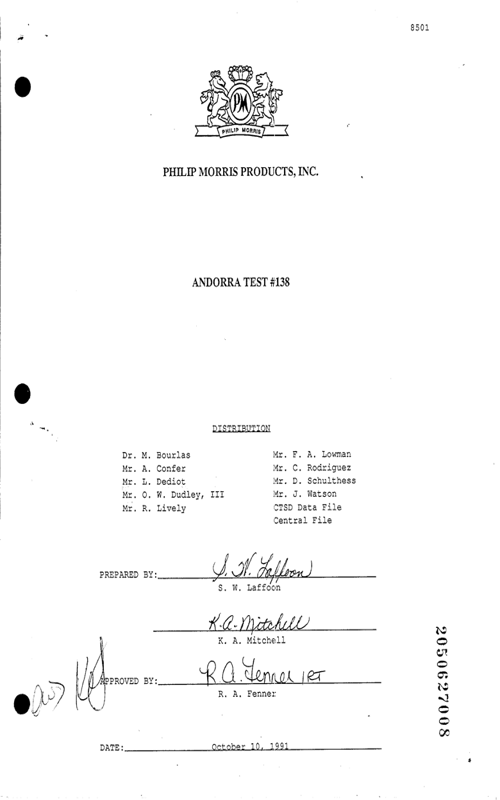

In [ ]:
print(sample['label'])
sample['image'].resize((500,800))